# Seguridad y Privacidad de los Datos - 2024/25

Last edited: 2025/03/25

# 0. Train the model on the provided dataset

In [40]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [41]:
pd.set_option('display.max_columns', None)

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
df

,sha256,label,timestamp,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,unused_permissions,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_

Cositas importantes:

* sha256 poco útil
* Ordenar en orden cronológico y dividir el entrenamiento (entrenar con las de hace 5 años y predecir actuales) dice que es interesante
* 'activities_count', 'providers_count','receivers_count' parecen interesantes según él
* 'api_calls_count' interesante
* 'unused_permissions' permisos pedidos pero no usados
* 'urls_count' cuantas urls se han encontrado dentro de la apk
* Probar varios modelos e ir quitando/poniendo caracteristicas
* Hay varias columnas con sus, que son llamadas a la api
* Hay que intentar hacer un modelo no muy bueno al principio para que sea bueno en general

In [42]:
df.columns

Index(['sha256', 'label', 'timestamp', 'activities_count', 'providers_count',
       'receivers_count', 'features_count', 'intent_filters_count',
       'api_calls_count', 'urls_count',
       ...
       'susp_getNetworkCountryIso', 'susp_getPackageInfo',
       'susp_getSimCountryIso', 'susp_getSubscriberId',
       'susp_getSystemService', 'susp_getWifiState', 'susp_sendTextMessage',
       'susp_setWifiDisabled', 'susp_setWifiEnabled', 'susp_system/bin/su'],
      dtype='object', length=358)

In [43]:
df.value_counts("label")

label
0    67771
1     7519
Name: count, dtype: int64

In [44]:
# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

df

,label,activities_count,providers_count,receivers_count,features_count,intent_filters_count,api_calls_count,urls_count,services_count,perm_android.permission.ACCESS_ALL_DOWNLOADS,perm_android.permission.ACCESS_BLUETOOTH_SHARE,perm_android.permission.ACCESS_CACHE_FILESYSTEM,perm_android.permission.ACCESS_CHECKIN_PROPERTIES,perm_android.permission.ACCESS_CONTENT_PROVIDERS_EXTERNALLY,perm_android.permission.ACCESS_DOWNLOAD_MANAGER,perm_android.permission.ACCESS_DOWNLOAD_MANAGER_ADVANCED,perm_android.permission.ACCESS_DRM_CERTIFICATES,perm_android.permission.ACCESS_EPHEMERAL_APPS,perm_android.permission.ACCESS_FM_RADIO,perm_android.permission.ACCESS_INPUT_FLINGER,perm_android.permission.ACCESS_KEYGUARD_SECURE_STORAGE,perm_android.permission.ACCESS_LOCATION_EXTRA_COMMANDS,perm_android.permission.ACCESS_MOCK_LOCATION,perm_android.permission.ACCESS_MTP,perm_android.permission.ACCESS_NETWORK_CONDITIONS,perm_android.permission.ACCESS_NETWORK_STATE,perm_android.permission.ACCESS_NOTIFICATIONS,perm_android.permission.ACCESS_NOTIFICATION_POLICY,perm_android.permission.ACCESS_PDB_STATE,perm_android.permission.ACCESS_SURFACE_FLINGER,perm_android.permission.ACCESS_VOICE_INTERACTION_SERVICE,perm_android.permission.ACCESS_VR_MANAGER,perm_android.permission.ACCESS_WIFI_STATE,perm_android.permission.ACCESS_WIMAX_STATE,perm_android.permission.ACCOUNT_MANAGER,perm_android.permission.ALLOW_ANY_CODEC_FOR_PLAYBACK,perm_android.permission.ASEC_ACCESS,perm_android.permission.ASEC_CREATE,perm_android.permission.ASEC_DESTROY,perm_android.permission.ASEC_MOUNT_UNMOUNT,perm_android.permission.ASEC_RENAME,perm_android.permission.AUTHENTICATE_ACCOUNTS,perm_android.permission.BACKUP,perm_android.permission.BATTERY_STATS,perm_android.permission.BIND_ACCESSIBILITY_SERVICE,perm_android.permission.BIND_APPWIDGET,perm_android.permission.BIND_CARRIER_MESSAGING_SERVICE,perm_android.permission.BIND_CARRIER_SERVICES,perm_android.permission.BIND_CHOOSER_TARGET_SERVICE,perm_android.permission.BIND_CONDITION_PROVIDER_SERVICE,perm_android.permission.BIND_CONNECTION_SERVICE,perm_android.permission.BIND_DEVICE_ADMIN,perm_android.permission.BIND_DIRECTORY_SEARCH,perm_android.permission.BIND_DREAM_SERVICE,perm_android.permission.BIND_INCALL_SERVICE,perm_android.permission.BIND_INPUT_METHOD,perm_android.permission.BIND_INTENT_FILTER_VERIFIER,perm_android.permission.BIND_JOB_SERVICE,perm_android.permission.BIND_KEYGUARD_APPWIDGET,perm_android.permission.BIND_MIDI_DEVICE_SERVICE,perm_android.permission.BIND_NFC_SERVICE,perm_android.permission.BIND_NOTIFICATION_LISTENER_SERVICE,perm_android.permission.BIND_NOTIFICATION_RANKER_SERVICE,perm_android.permission.BIND_PACKAGE_VERIFIER,perm_android.permission.BIND_PRINT_RECOMMENDATION_SERVICE,perm_android.permission.BIND_PRINT_SERVICE,perm_android.permission.BIND_PRINT_SPOOLER_SERVICE,perm_android.permission.BIND_QUICK_SETTINGS_TILE,perm_android.permission.BIND_REMOTEVIEWS,perm_android.permission.BIND_REMOTE_DISPLAY,perm_android.permission.BIND_ROUTE_PROVIDER,perm_android.permission.BIND_RUNTIME_PERMISSION_PRESENTER_SERVICE,perm_android.permission.BIND_SCREENING_SERVICE,perm_android.permission.BIND_TELECOM_CONNECTION_SERVICE,perm_android.permission.BIND_TEXT_SERVICE,perm_android.permission.BIND_TRUST_AGENT,perm_android.permission.BIND_TV_INPUT,perm_android.permission.BIND_TV_REMOTE_SERVICE,perm_android.permission.BIND_VOICE_INTERACTION,perm_android.permission.BIND_VPN_SERVICE,perm_android.permission.BIND_VR_LISTENER_SERVICE,perm_android.permission.BIND_WALLPAPER,perm_android.permission.BLUETOOTH,perm_android.permission.BLUETOOTH_ADMIN,perm_android.permission.BLUETOOTH_MAP,perm_android.permission.BLUETOOTH_PRIVILEGED,perm_android.permission.BLUETOOTH_STACK,perm_android.permission.BRICK,perm_android.permission.BROADCAST_NETWORK_PRIVILEGED,perm_android.permission.BROADCAST_PACKAGE_REMOVED,perm_android.permission.BROADCAST_SMS,perm_android.permission.BROADCAST_STICKY,perm_android.permission.BROADCAST_WAP_PUSH,perm_android.permission.CACHE_C

In [45]:
# Initialize the Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((56467, 354), (18823, 354), (56467,), (18823,))

In [46]:
# Train the model
rf_model.fit(X_train, y_train)

# Evaluate the model on the training set
train_accuracy = rf_model.score(X_train, y_train)
print(f"Training Accuracy: {train_accuracy:.4f}")

# Evaluate the model on the test set
test_accuracy = rf_model.score(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

,Feature,Importance
6,urls_count,0.075300
5,api_calls_count,0.071175
347,susp_getSubscriberId,0.049175
0,activities_count,0.046240
204,perm_android.permission.MOUNT_UNMOUNT_FILESYSTEMS,0.038869
298,perm_android.permission.SYSTEM_ALERT_WINDOW,0.037456
154,perm_android.permission.GET_TASKS,0.035280
4,intent_filters_count,0.029293
7,services_count,0.027240
2,receivers_count,0.025705


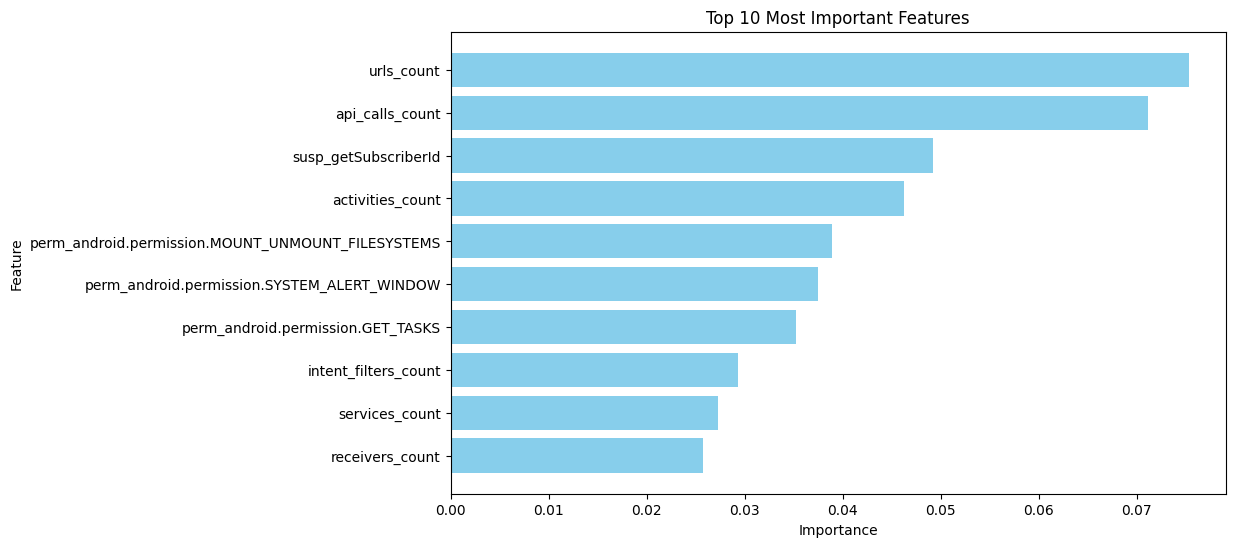

In [33]:
# Obtener las características más importantes
feature_importances = rf_model.feature_importances_

# Crear un DataFrame para visualizar las importancias
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

# Mostrar las 10 características más importantes
display(importance_df.head(10))

# Plot the feature importances
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'].head(10), importance_df['Importance'].head(10), color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Most Important Features')
plt.gca().invert_yaxis()  # Invert y-axis to show the most important feature at the top
plt.show()

In [37]:
import seaborn as sns

# Estadísticas descriptivas de urls_count por label
urls_count_stats = df.groupby('label')['urls_count'].describe()
print(urls_count_stats)

         count       mean       std  min   25%   50%   75%     max
label                                                             
0      67771.0  44.890661  77.88022  0.0  17.0  30.0  51.0  6297.0
1       7519.0  48.302301  82.87415  0.0   0.0  15.0  61.0  1983.0


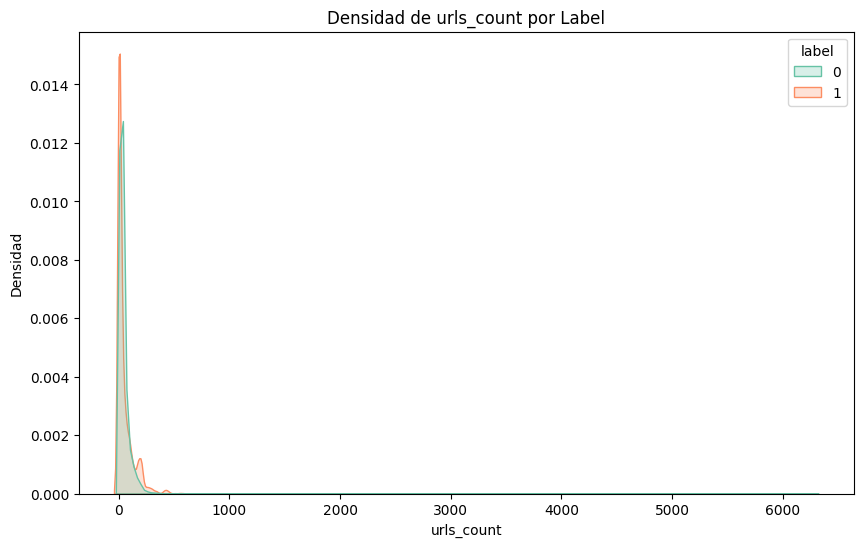

In [38]:
# Visualización de la densidad de urls_count por label
plt.figure(figsize=(10, 6))
sns.kdeplot(data=df, x='urls_count', hue='label', common_norm=False, fill=True, palette='Set2')
plt.title('Densidad de urls_count por Label')
plt.xlabel('urls_count')
plt.ylabel('Densidad')
plt.show()

/var/folders/mx/md71j6pn00l970kj45sznh5h0000gn/T/ipykernel_89691/821809998.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')


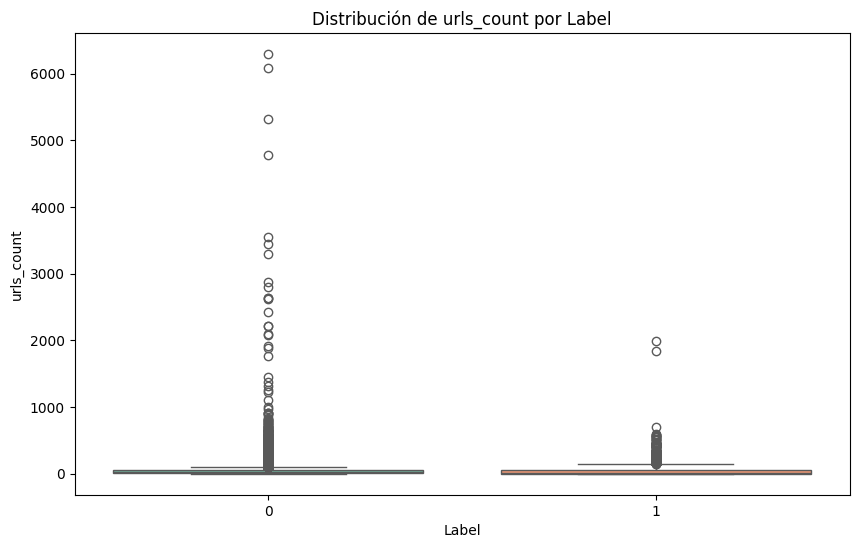

In [36]:
# Visualización de la distribución de urls_count por label
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='label', y='urls_count', palette='Set2')
plt.title('Distribución de urls_count por Label')
plt.xlabel('Label')
plt.ylabel('urls_count')
plt.show()

# 1. Perform at least one black-box attack and one white-box attack on the model. You may perform additional attacks as desired.

- Black box
- White box

## Black Box

## White Box

In [39]:
# Seleccionar una fila del conjunto de prueba
sample_index = 0  # Cambia este índice para probar con diferentes filas
sample_row = X_test.iloc[sample_index:sample_index + 1]

aux_sample_row = X_test.iloc[sample_index:sample_index + 1]
aux_sample_row["urls_count_stats"] = 0

# Realizar la predicción
predicted_label = rf_model.predict(sample_row)[0]
aux_label = rf_model.predict(aux_sample_row)[0]

# Obtener el ground truth
ground_truth_label = y_test.iloc[sample_index]

# Imprimir los resultados
print(f"Predicted Label: {predicted_label}")
print(f"Predicted Label: {aux_label}")
print(f"Ground Truth Label: {ground_truth_label}")

/var/folders/mx/md71j6pn00l970kj45sznh5h0000gn/T/ipykernel_89691/378529410.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aux_sample_row["urls_count_stats"] = 0


ValueError: The feature names should match those that were passed during fit.
Feature names unseen at fit time:
- urls_count_stats


# 2. Prove that your model can be more robust to adversarial examples

Demonstrate that your model maintains high accuracy when subjected to adversarial examples. Provide empirical evidence of robustness by evaluating performance under adversarial attacks.

What Will Be Valued:
- Effective adversarial attack methods and proper defense mechanisms.
- Clear evaluation metrics comparing standard vs. adversarial performance.
- Well-documented methodology and reproducibility of results.

# 3. Try to attack this model

You will be given the anonymous model `android_permission_model.onnx`, previously trained on the provided dataset. 
Analyze the model’s weaknesses by testing different black-box attack strategies.

What Will Be Valued:
- Use of diverse adversarial attack techniques.
- Quantitative analysis of attack effectiveness with relevant metrics.
- Clear documentation of the attack process and reproducibility.

Below, you can find an example on model loading and inference. The model expects every column in the dataset except for `sha256`, `timestamp` and `unused_permissions`.
The model is loaded in an [onnx runtime](https://onnxruntime.ai/docs/api/python/api_summary.html). 

In [5]:
import os
import numpy as np
import pandas as pd
import onnxruntime as rt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

DATASET_ROUTE = './dataset.csv'

df = pd.read_csv(DATASET_ROUTE)
model_path = 'android_permission_model.onnx'

# removing unused columns
if 'timestamp' in df.columns:
    df = df.drop('timestamp', axis=1)
if 'unused_permissions' in df.columns:
    df = df.drop('unused_permissions', axis=1)
if 'sha256' in df.columns:
    df = df.drop('sha256', axis=1)

# features and target separation + train/test split
X = df.drop('label', axis=1)
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

Example inference function using [sess.run()](https://onnxruntime.ai/docs/api/python/api_summary.html#onnxruntime.InferenceSession.run):

In [21]:
def onnx_inference(model_path, test_data):
    """
    Function to load and make predictions with an ONNX model
    """
    # open ONNX inference session
    sess = rt.InferenceSession(model_path)
    
    # input and output names
    input_name = sess.get_inputs()[0].name
    output_names = [output.name for output in sess.get_outputs()]
    
    # send inputs to the model and obtain predictions
    results = sess.run(output_names, {input_name: test_data.astype(np.float32)})

    return results[0]       # results[0] are discrete predicted labels, while results[1] are probabilities

In [22]:
# try and load the model
if not os.path.exists(model_path):
    print(f"Error: Model file '{model_path}' not found!")
    print(f"Current working directory: {os.getcwd()}")
    print(f"Files in current directory: {os.listdir('.')}")
else:
    # small sample to test if it works
    test_sample = X_test.iloc[:5].values
    onnx_predictions = onnx_inference(model_path, test_sample)
    
    if onnx_predictions is not None:
        print("\nONNX Model Predictions (sample):")
        print(onnx_predictions)
        
        # compare with actual labels
        actual_labels = y_test.iloc[:5].values
        print("\nActual labels:")
        print(actual_labels)
    
    # full test set now
    print("\nONNX Model Predictions (full test set):")
    full_predictions = onnx_inference(model_path, X_test.values)

    try:
        print(f"Accuracy: {accuracy_score(y_test, full_predictions):.4f}")
        print("\nClassification Report:")
        print(classification_report(y_test, full_predictions))
        print("\nConfusion Matrix:")
        print(confusion_matrix(y_test, full_predictions))
    except Exception as e:
        print(f"Error during ONNX prediction: {e}")


ONNX Model Predictions (sample):
[1 0 0 0 1]

Actual labels:
[1 0 0 0 0]

ONNX Model Predictions (full test set):
Accuracy: 0.9815

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     16943
           1       0.86      0.97      0.91      1880

    accuracy                           0.98     18823
   macro avg       0.93      0.98      0.95     18823
weighted avg       0.98      0.98      0.98     18823


Confusion Matrix:
[[16642   301]
 [   48  1832]]
